In [2]:
#Preprocessing the datasets
import pandas as pd

#Solar Radiation Datasets Preprocessing
def preprocess_radiation(df):
    # Ensure datetime index
    if "Year" in df.columns:
        df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute"]])
        df = df.drop(columns=["Year", "Month", "Day", "Hour", "Minute"])
    elif "Unnamed: 0" in df.columns:
        df = df.rename(columns={"Unnamed: 0": "Datetime"})
        df["Datetime"] = pd.to_datetime(df["Datetime"])
    elif "Time" in df.columns:
        df["Datetime"] = pd.to_datetime(df["Time"])
        df = df.drop(columns=["Time"])

    df = df.set_index("Datetime")

    # Keep only useful columns
    useful_cols = [
        "Temperature", "Pressure", "Wind Speed", "Wind Direction",
        "Precipitable Water", "Cloud Type", "Surface Albedo",
        "Solar Zenith Angle", "Solar Azimuth Angle",
        "GHI", "DNI", "DHI", "Clearsky GHI", "Clearsky DNI", "Clearsky DHI"
    ]
    df = df[[c for c in useful_cols if c in df.columns]]

    return df

#Solar Power Dataset Preprocessing
def preprocess_power(df):
    if "LocalTime" in df.columns:
        try:
            df["Datetime"] = pd.to_datetime(df["LocalTime"], format="mixed")
        except Exception:
            # Fallback for mixed formats
            df["Datetime"] = pd.to_datetime(df["LocalTime"], dayfirst=True, errors="coerce")
            mask = df["Datetime"].isna()
            if mask.any():
                df.loc[mask, "Datetime"] = pd.to_datetime(
                    df.loc[mask, "LocalTime"], errors="coerce"
                )

        df = df.drop(columns=["LocalTime"])

    df = df.set_index("Datetime")

    # Rename power column for consistency
    if "Power(MW)" in df.columns:
        df = df.rename(columns={"Power(MW)": "Power"})

    # Resample to hourly mean to match radiation dataset
    df = df.resample("1H").mean()

    return df

#Example Usage
# Load datasets
radiation_2006 = pd.read_csv("/content/solar_radiation_2006.csv", skiprows=2)
radiation_2024 = pd.read_csv("/content/solar_radiation_2024.csv", skiprows=2)
power_2006 = pd.read_csv("/content/solar_power_2006.csv")

# Preprocess
radiation_2006 = preprocess_radiation(radiation_2006)
radiation_2024 = preprocess_radiation(radiation_2024)
power_2006 = preprocess_power(power_2006)

# Merge aligned datasets (2006 radiation + 2006 power)
data_2006 = radiation_2006.join(power_2006, how="inner")

print("2006 merged shape:", data_2006.shape)
print(data_2006.head())

2006 merged shape: (8760, 16)
                     Temperature  Pressure  Wind Speed  Wind Direction  \
Datetime                                                                 
2006-01-01 00:00:00         11.8     908.0         5.9           210.0   
2006-01-01 01:00:00         10.8     908.0         5.7           202.0   
2006-01-01 02:00:00         10.3     908.0         5.9           204.0   
2006-01-01 03:00:00         10.0     908.0         5.6           213.0   
2006-01-01 04:00:00          9.4     909.0         4.7           228.0   

                     Precipitable Water  Cloud Type  Surface Albedo  \
Datetime                                                              
2006-01-01 00:00:00                 1.5         6.0            0.26   
2006-01-01 01:00:00                 1.3         0.0            0.26   
2006-01-01 02:00:00                 1.1         0.0            0.26   
2006-01-01 03:00:00                 1.0         4.0            0.26   
2006-01-01 04:00:00      

/tmp/ipython-input-534996377.py:53: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - loss: 0.0594 - val_loss: 0.0235
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0229 - val_loss: 0.0161
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0179 - val_loss: 0.0144
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.0159 - val_loss: 0.0125
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0140 - val_loss: 0.0126
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0130 - val_loss: 0.0109
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 0.0121 - val_loss: 0.0106
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.0107 - val_loss: 0.0097
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.0094 - val_loss: 0.0106
Epoch 12/100
219/21

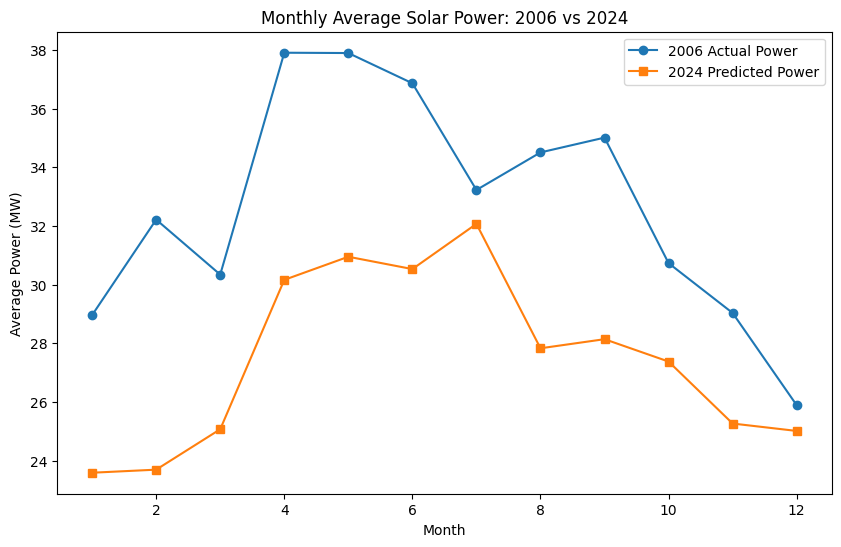

In [ ]:
#LSTM MODEL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ---------------------------
# 1. Prepare training data
# ---------------------------
# Merge radiation + power datasets for 2006
data_2006 = radiation_2006.merge(power_2006, left_index=True, right_index=True)

features = radiation_2006.columns
target = "Power"

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data_2006[features])
y_scaled = scaler_y.fit_transform(data_2006[[target]])

# Sequence generator
def create_sequences(X, y, seq_length=24):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 24
X, y = create_sequences(X_scaled, y_scaled, seq_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------------------
# 2. Build optimized LSTM model
# ---------------------------
model = Sequential([
    LSTM(192, return_sequences=True,
         input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    LSTM(96, kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss="mse")

early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# ---------------------------
# 3. Evaluate performance
# ---------------------------
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_inv = scaler_y.inverse_transform(y_train)
y_test_inv = scaler_y.inverse_transform(y_test)
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)

def regression_metrics(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)
    exp_var = explained_variance_score(y_true, y_pred)
    print(f"📊 {label} Metrics: RMSE={rmse:.3f}, MAE={mae:.3f}, "
          f"R²={r2:.3f}, Median AE={med_ae:.3f}, ExpVar={exp_var:.3f}")

regression_metrics(y_train_inv, y_train_pred_inv, "Train")
regression_metrics(y_test_inv, y_test_pred_inv, "Test")

# ---------------------------
# 4. Predict for 2024
# ---------------------------
X_2024_scaled = scaler_X.transform(radiation_2024[features])
X_2024_seq, _ = create_sequences(X_2024_scaled, np.zeros(len(X_2024_scaled)), seq_length)

y_2024_pred_scaled = model.predict(X_2024_seq)
y_2024_pred = scaler_y.inverse_transform(y_2024_pred_scaled)

dates_2024 = radiation_2024.index[seq_length:]
predicted_power_2024 = pd.Series(y_2024_pred.flatten(), index=dates_2024)

# ---------------------------
# 5. Monthly comparison plot
# ---------------------------
monthly_2006 = power_2006.resample("ME").mean()
monthly_2024 = predicted_power_2024.resample("ME").mean()

plt.figure(figsize=(10,6))
plt.plot(monthly_2006.index.month, monthly_2006.values, label="2006 Actual Power", marker="o")
plt.plot(monthly_2024.index.month, monthly_2024.values, label="2024 Predicted Power", marker="s")
plt.title("Monthly Average Solar Power: 2006 vs 2024")
plt.xlabel("Month")
plt.ylabel("Average Power (MW)")
plt.legend()
plt.show()

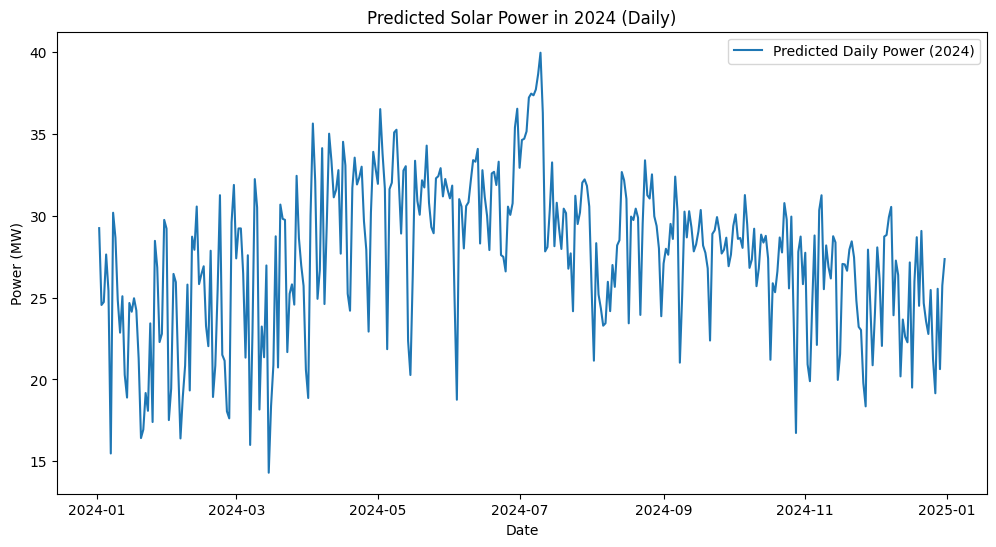

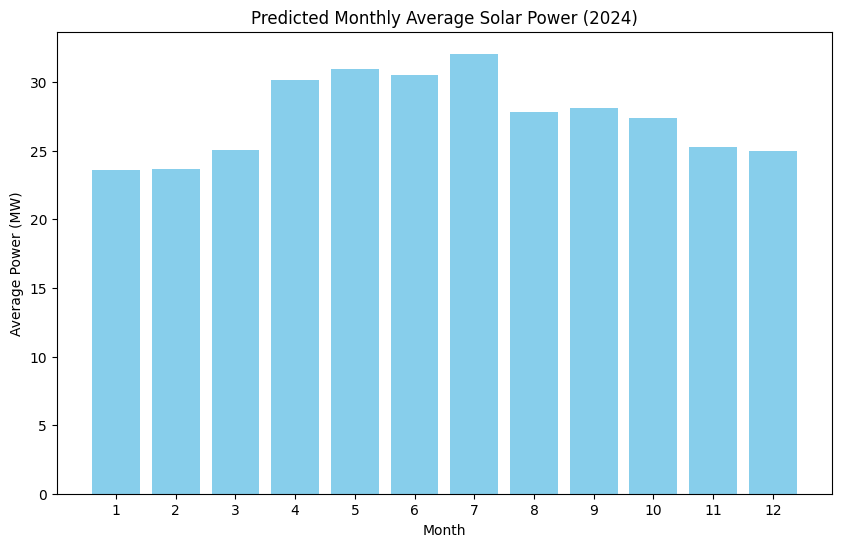

/tmp/ipython-input-2234293539.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Month", y="Power", data=daily_2024_df, palette="Blues")


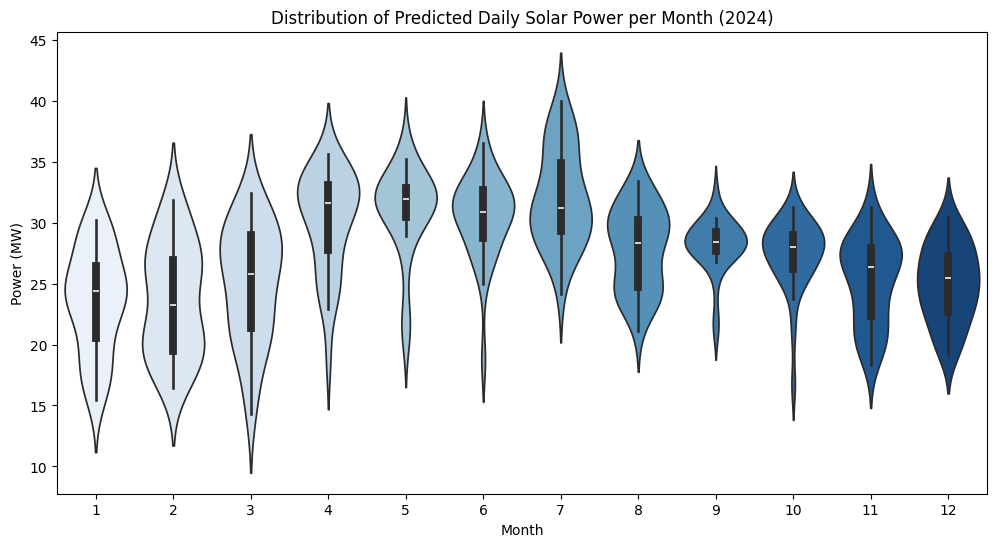

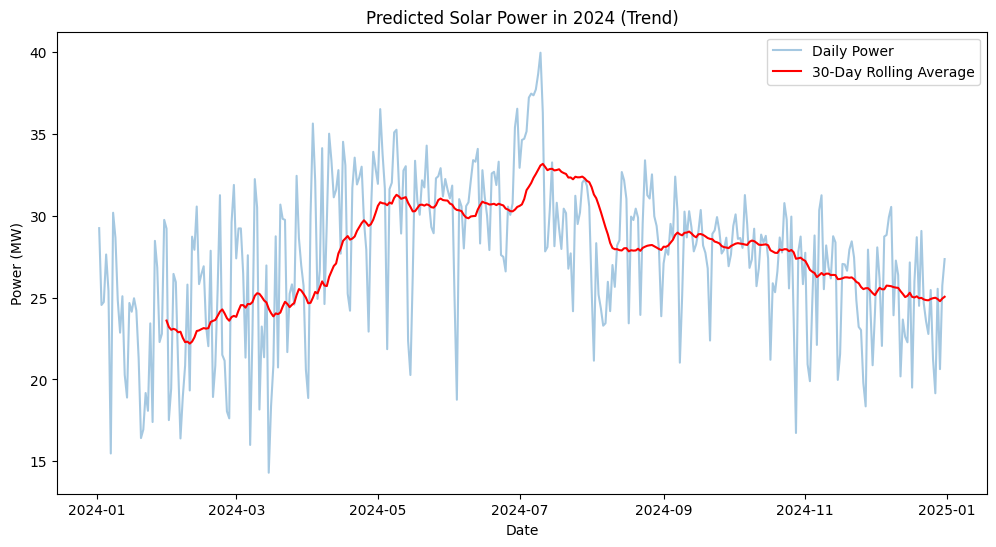

In [ ]:
# ---------------------------
# Visualization of Predicted 2024 Power
# ---------------------------

# Daily values
daily_2024 = predicted_power_2024.resample("D").mean()

# Monthly averages
monthly_2024 = predicted_power_2024.resample("ME").mean()

# 1. Time series line plot
plt.figure(figsize=(12,6))
plt.plot(daily_2024.index, daily_2024.values, label="Predicted Daily Power (2024)")
plt.title("Predicted Solar Power in 2024 (Daily)")
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.legend()
plt.show()

# 2. Monthly average bar chart
plt.figure(figsize=(10,6))
plt.bar(monthly_2024.index.month, monthly_2024.values, color="skyblue")
plt.title("Predicted Monthly Average Solar Power (2024)")
plt.xlabel("Month")
plt.ylabel("Average Power (MW)")
plt.xticks(range(1,13))
plt.show()

import seaborn as sns

# 3. Monthly average violin plot
daily_2024_df = daily_2024.to_frame(name="Power")
daily_2024_df["Month"] = daily_2024_df.index.month

plt.figure(figsize=(12,6))
sns.violinplot(x="Month", y="Power", data=daily_2024_df, palette="Blues")
plt.title("Distribution of Predicted Daily Solar Power per Month (2024)")
plt.xlabel("Month")
plt.ylabel("Power (MW)")
plt.show()



# 4. Rolling mean (30-day trend)
plt.figure(figsize=(12,6))
plt.plot(daily_2024.index, daily_2024.values, alpha=0.4, label="Daily Power")
plt.plot(daily_2024.index, daily_2024.rolling(30).mean(),
         color="red", label="30-Day Rolling Average")
plt.title("Predicted Solar Power in 2024 (Trend)")
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.legend()
plt.show()

0:	learn: 0.2779492	total: 13.4ms	remaining: 6.69s
100:	learn: 0.0738211	total: 2.55s	remaining: 10.1s
200:	learn: 0.0626357	total: 4.32s	remaining: 6.43s
300:	learn: 0.0548508	total: 5.54s	remaining: 3.67s
400:	learn: 0.0492446	total: 6.74s	remaining: 1.66s
499:	learn: 0.0452724	total: 7.92s	remaining: 0us
📊 Train Metrics: RMSE=7.049, MAE=3.653, R²=0.976, Median AE=0.933, ExpVar=0.976
📊 Test Metrics: RMSE=13.974, MAE=7.443, R²=0.886, Median AE=2.275, ExpVar=0.894
2024 predictions (CatBoost) sample:
Datetime
2024-01-01 00:00:00    4.082882
2024-01-01 01:00:00    0.297554
2024-01-01 02:00:00    0.271730
2024-01-01 03:00:00    0.180210
2024-01-01 04:00:00   -0.233367
dtype: float64


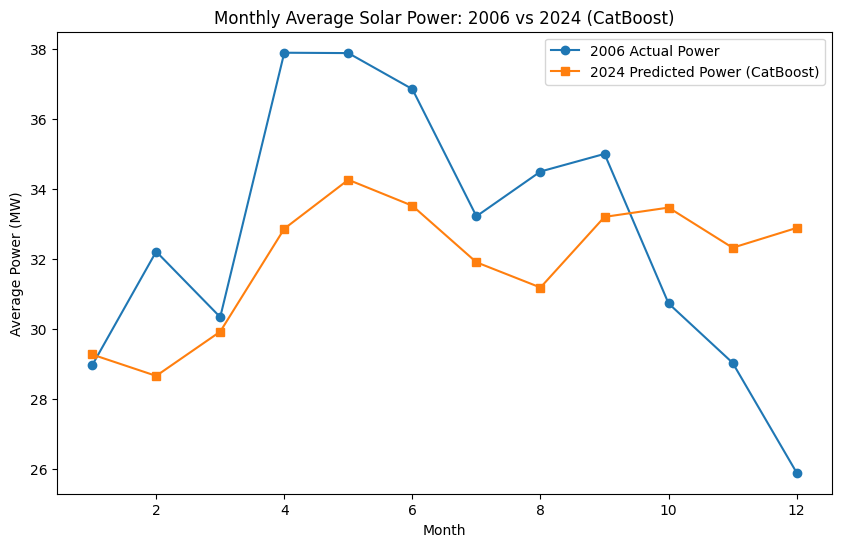

In [ ]:
# GRADIENT BOOSTING WITH CATBOOST (preliminary approach - unsucessful)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler

# ---------------------------
# 1. Prepare training data (2006)
# ---------------------------
data_2006 = radiation_2006.merge(power_2006, left_index=True, right_index=True)

features = radiation_2006.columns
target = "Power"

X_2006 = data_2006[features]
y_2006 = data_2006[target]

# Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_2006_scaled = scaler_X.fit_transform(X_2006)
y_2006_scaled = scaler_y.fit_transform(y_2006.values.reshape(-1,1)).ravel()

# ---------------------------
# 2. Train/test split (2006 only, for evaluation)
# ---------------------------
split = int(0.8 * len(X_2006_scaled))
X_train, X_test = X_2006_scaled[:split], X_2006_scaled[split:]
y_train, y_test = y_2006_scaled[:split], y_2006_scaled[split:]

# ---------------------------
# 3. Train CatBoost
# ---------------------------
cat_model = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="RMSE",
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train)

# ---------------------------
# 4. Evaluate on 2006 test set
# ---------------------------
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

# Inverse transform back to MW
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1,1)).ravel()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel()
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred.reshape(-1,1)).ravel()
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred.reshape(-1,1)).ravel()

def regression_metrics(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)
    exp_var = explained_variance_score(y_true, y_pred)
    print(f"📊 {label} Metrics: RMSE={rmse:.3f}, MAE={mae:.3f}, "
          f"R²={r2:.3f}, Median AE={med_ae:.3f}, ExpVar={exp_var:.3f}")

regression_metrics(y_train_inv, y_train_pred_inv, "Train")
regression_metrics(y_test_inv, y_test_pred_inv, "Test")

# ---------------------------
# 5. Predict 2024
# ---------------------------
X_2024_scaled = scaler_X.transform(radiation_2024[features])
y_2024_pred_scaled = cat_model.predict(X_2024_scaled)
y_2024_pred = scaler_y.inverse_transform(y_2024_pred_scaled.reshape(-1,1)).ravel()

predicted_power_2024_cat = pd.Series(y_2024_pred, index=radiation_2024.index)

print("2024 predictions (CatBoost) sample:")
print(predicted_power_2024_cat.head())

# ---------------------------
# 6. Monthly comparison plot
# ---------------------------
monthly_2006 = power_2006.resample("ME").mean()
monthly_2024_cat = predicted_power_2024_cat.resample("ME").mean()

plt.figure(figsize=(10,6))
plt.plot(monthly_2006.index.month, monthly_2006.values, label="2006 Actual Power", marker="o")
plt.plot(monthly_2024_cat.index.month, monthly_2024_cat.values, label="2024 Predicted Power (CatBoost)", marker="s")
plt.title("Monthly Average Solar Power: 2006 vs 2024 (CatBoost)")
plt.xlabel("Month")
plt.ylabel("Average Power (MW)")
plt.legend()
plt.show()
